In [1]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('df_no_lag.csv')

In [4]:
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    AutoARIMA,
    VARIMA,
    ExponentialSmoothing,
    Theta
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [6]:
pd.set_option('display.max_columns', None)

In [7]:
df.head()

,Unnamed: 0,TimeInterval,Date,TOD,Season,AT_PAX,Taxi_PAX,Weather,Parking#,FHV#,holiday,total_doses,pax_intl_bus,pax_intl_lei,pax_dom_bus,pax_dom_lei
0,0,2021-03-13 00:00:00,2021-03-13 00:00:00,Overnight,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
1,1,2021-03-13 00:10:00,2021-03-13 00:00:00,Overnight,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
2,2,2021-03-13 00:20:00,2021-03-13 00:00:00,Overnight,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
3,3,2021-03-13 00:30:00,2021-03-13 00:00:00,Overnight,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
4,4,2021-03-13 00:40:00,2021-03-13 00:00:00,Overnight,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0


In [8]:
df.drop(['Unnamed: 0'],axis=1, inplace=True)

In [9]:
df['TimeInterval'] = pd.to_datetime(df['TimeInterval'])

In [10]:
df = df.drop_duplicates(subset=['TimeInterval'])

In [11]:
df.duplicated(keep=False).sum()

0

In [12]:
df.set_index('TimeInterval',inplace=True)

In [13]:
df.drop(['Date'],axis=1, inplace=True)

In [14]:
df.drop(['TOD'],axis=1, inplace=True)

In [15]:
covariates = df[df.columns[~df.columns.isin(['AT_PAX','Taxi_PAX','Parking#','FHV#'])]]
targets = df[['AT_PAX','Taxi_PAX','Parking#','FHV#']]

In [16]:
df.index = pd.to_datetime(df.index)

In [17]:
cov = TimeSeries.from_dataframe(covariates,freq='10T')
tar = TimeSeries.from_dataframe(targets,freq='10T')

In [18]:
sc_cov = Scaler()
cov_sc = sc_cov.fit_transform(cov)

sc_tar = Scaler()
tar_sc = sc_tar.fit_transform(tar)

In [19]:
cov_train, cov_test = cov_sc.split_before(pd.Timestamp(2021,10,1))
tar_train, tar_test = tar_sc.split_before(pd.Timestamp(2021,10,1))

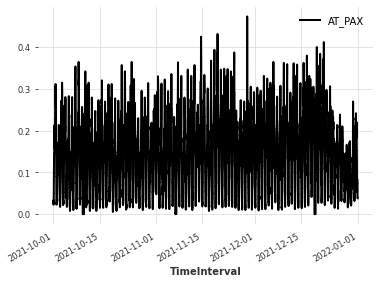

In [20]:
tar_test['AT_PAX'].plot()

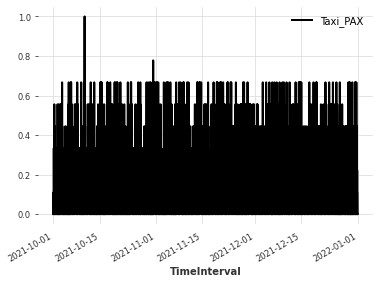

In [21]:
tar_test['Taxi_PAX'].plot()

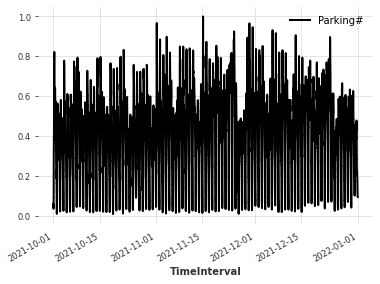

In [22]:
tar_test['Parking#'].plot()

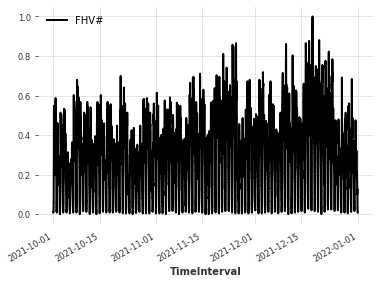

In [23]:
tar_test['FHV#'].plot()

In [24]:
m_nbeats = NBEATSModel(
    input_chunk_length=2016,
    output_chunk_length=1008,
    n_epochs=5
)

In [25]:
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=2016,
    output_chunk_length=1008,
    n_epochs=2
)

In [26]:
model_cov.fit(
    series=tar_train,
    past_covariates= cov_train,
    verbose=True,
)

2022-07-19 05:11:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 26065 samples.
2022-07-19 05:11:46 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-19 05:11:46 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-07-19 05:11:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-19 05:11:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-07-19 05:11:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
2022-07-19 05:11:46 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Pa

Training: 0it [00:00, ?it/s]

In [27]:
pred = model_cov.predict(len(tar_test), series=tar_train, past_covariates=cov_sc)

Predicting: 815it [00:00, ?it/s]

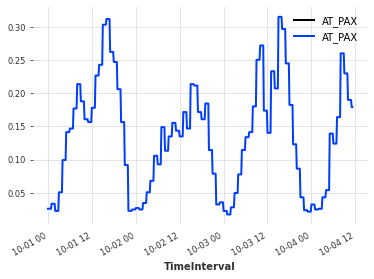

In [33]:
pred['AT_PAX'][:500].plot()
tar_test['AT_PAX'][:500].plot()

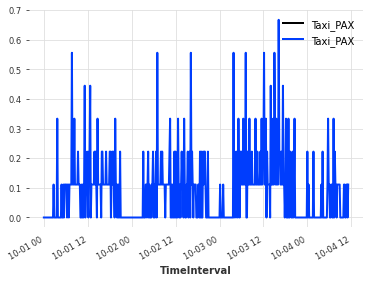

In [34]:
pred['Taxi_PAX'][:500].plot()
tar_test['Taxi_PAX'][:500].plot()

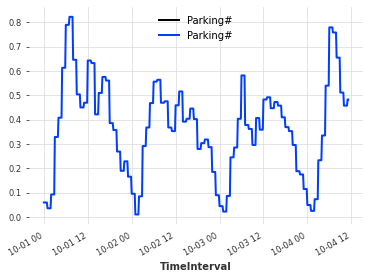

In [42]:
pred['Parking#'][:500].plot()
tar_test['Parking#'][:500].plot()

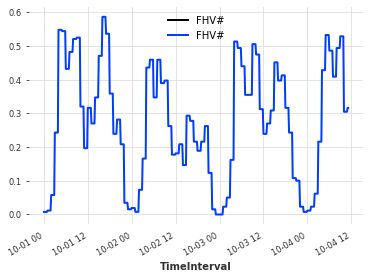

In [43]:
pred['FHV#'][:500].plot()
tar_test['FHV#'][:500].plot()

In [44]:
#PREDICT VALUES DO NOT SHOW UP 

In [45]:
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.utils import SeasonalityMode

In [46]:
m_theta = Theta(season_mode= SeasonalityMode.ADDITIVE)
m_theta.fit(tar_train['AT_PAX'])

In [47]:
pred = m_theta.predict(len(tar_test['AT_PAX']))


In [48]:
res_smape = smape(tar_test['AT_PAX'], pred)
print(res_smape)

56.685326959355564


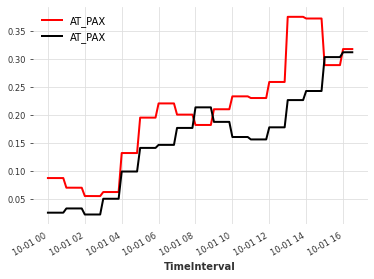

In [49]:
pred[:100].plot(c='r')
tar_test[:100]['AT_PAX'].plot()